# Generative Radio Channel with Synthetic Data

This notebook serves as the synthetic dataset generation. I try to create 1000 samples. 800 for training, 100 for validation, and 100 for testing. A sample room is provided as an SVG made with Inkscape. I did this so that I have something to work with when exploring FSPL and Multi-Wall models. Also so that we can arbitrarily create rooms using Inkscape, save to SVG, and try out our glorious model.

Based on COST INTERACT paper

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/ai_in_wireless`


In [2]:
using Plots
using Printf: @printf, @sprintf

In [3]:
include("map.jl")
include("signals.jl")

multiwall_heatmap (generic function with 1 method)

Suppose that we have three transmitter locations:
1. $(20.0, 30.0)$
2. $(4.0, 9.0)$
3. $(98.0, 78.0)$

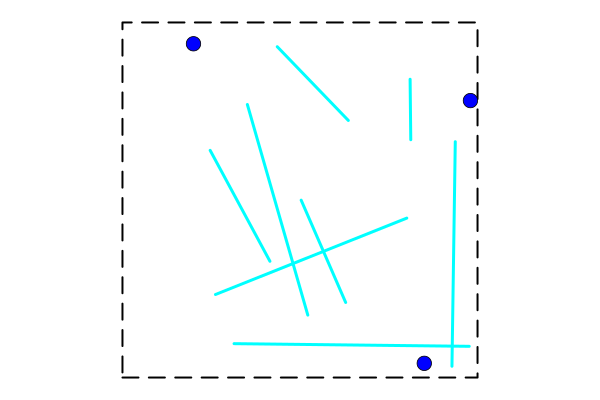

In [4]:
transmitters = Point{2, Float32}[
    Point2f(20.0, 94.0),
    Point2f(85.0, 4.0),
    Point2f(98.0, 78.0),
]

room = loadroom("map1.svg"; transmitters = transmitters)
p = plotroom(room)

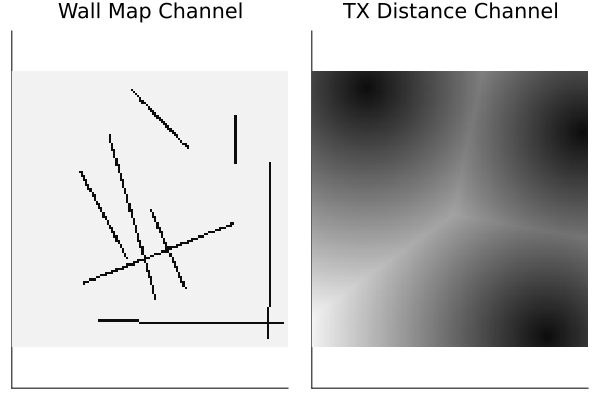

In [5]:
rs = rasterize(room)
rs_plot1 = heatmap(abs.(1 .- rs[:, :, 1])', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "Wall Map Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

rs_plot2 = heatmap(rs[:,:,2]', 
    c = :grays, 
    aspect_ratio = :equal, 
    title = "TX Distance Channel",
    axis=nothing,
    ticks=nothing,
    legend=nothing,
)

plot(rs_plot1, rs_plot2)

### Free Space Path Loss

Let the receiver be $R = (x_r, y_r)$ and transmitters be $T_i = (x_i, y_i)$. 

The euclidean distance from the receiver to each transmitter $i$ is
$$
d_i = \sqrt{(x_r - x_i)^2 + (y_r - y_i)^2}
$$

So the FSPL (from lecture slides) for each transmitter is
$$
L_{i,\text{dB}} = 20\log_{10} f + 20\log_{10} d + 32.45
$$
where $f$ is the signal frequency in Gigahertz

In [6]:
rx = Point2f(30.0f0, 56.0f0)
fspl(Point2f(20.0f0, 94.0f0), rx)

79.75351257324219

In [7]:
fspl(room, rx)

3-element Vector{Float64}:
 79.75351257324219
 85.44782943725586
 84.94955368041992

In [8]:
hmap = fspl_map(room)

100×100×3 Array{Float32, 3}:
[:, :, 1] =
 87.4143  87.3242  87.2332  87.1413  …  73.5491  73.6305  73.7329  73.8549
 87.3964  87.3059  87.2145  87.1222     73.0915  73.1818  73.2953  73.4301
 87.3794  87.2886  87.1968  87.1041     72.6092  72.71    72.8363  72.9859
 87.3634  87.2722  87.1801  87.087      72.0995  72.2127  72.3541  72.5209
 87.3482  87.2567  87.1643  87.0709     71.5592  71.6872  71.8464  72.0334
 87.334   87.2422  87.1495  87.0557  …  70.9846  71.1304  71.311   71.5219
 87.3207  87.2287  87.1356  87.0416     70.3712  70.5388  70.7451  70.9846
 87.3084  87.2161  87.1227  87.0284     69.714   69.9082  70.1459  70.4198
 87.297   87.2044  87.1109  87.0163     69.0065  69.2342  69.5106  69.826
 87.2866  87.1938  87.1     87.0052     68.2413  68.5116  68.8361  69.2024
 87.2772  87.1842  87.0901  86.9951  …  67.4095  67.7348  68.1201  68.5489
 87.2687  87.1755  87.0813  86.9861     66.5003  66.8979  67.3609  67.867
 87.2612  87.1679  87.0735  86.9781     65.5013  65.9962  66.

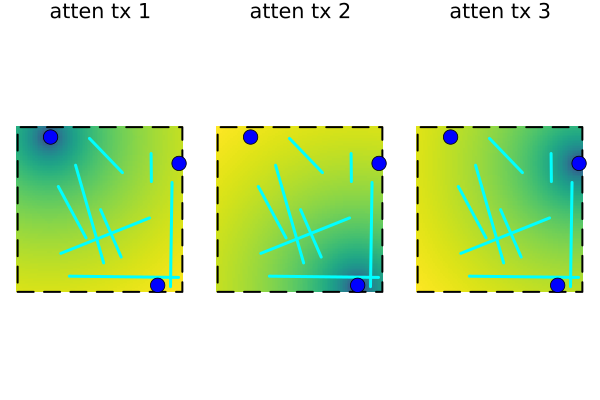

In [9]:
heatmap_plots = [
    plot_discrete_heatmap(room, hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

Heatmap when considering which TX is used by the RX based on attenuation

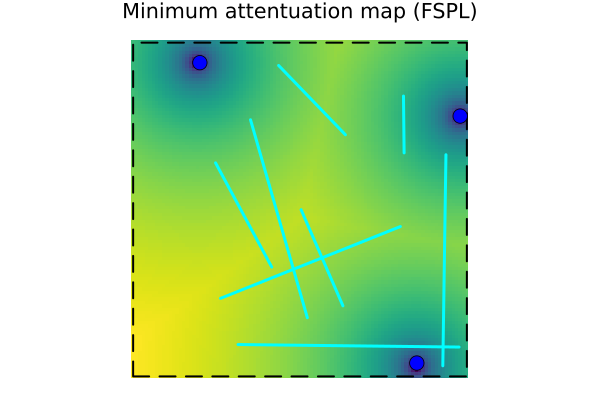

In [10]:
plot_discrete_heatmap(room, minimum(hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (FSPL)")

### Multi-Wall Model

**Source**: https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf

To create the ground truth for the model, we make use of [Multi-Wall Model](https://thesai.org/Downloads/Volume12No4/Paper_94-Integrating_Cost_231_Multiwall_Propagation.pdf). This considers obstacles around the transmitter.

$$
L_{MW} = L_{FSL}(d) + \sum_{i=1}^N k_{wi}L_{wi} + k_fL_f
$$

where
* $L_{FSL}(d)$ - FSPL dependent on the distance $d$ and frequency $f$ (Given above)
* $N$ - Total number of different wall types
* $k_{wi}$ - number of walls of type $i$ that the direct signal path intersects.
* $L_{wi}$ - Attenuation factor (loss in dB) for a wall of type $i$
* $k_fL_f$ - Loss due floors due to multiple levels.

Since we only have 2D environment, then $k_fL_f=0$. Furthermore, suppose that all walls are concrete walls. The Cost 231 paper says that the attenuation for this type of wall will be 12 dB (assuming frequency of 2.4 GHz).

This greatly simplifies our multi-wall function to:

$$
L_{i,MW} = L_{i,\text{dB}}(d) + 12k
$$

where $k$ is the number of walls that intersects the ray between the TX and the RX.

In [11]:
count_walls(room, Point2f(50.0, 50.0))

3-element Vector{Int64}:
 1
 3
 1

In [12]:
mw_hmap = multiwall_heatmap(room; σ=3.0)

100×100×3 Array{Float32, 3}:
[:, :, 1] =
  86.8531   87.4996   86.9815  …  75.2692  76.0438  76.7245  74.6076
  82.4112   87.949    87.4719     69.5345  76.6395  73.0989  71.2558
  87.2655   86.4582   88.2279     75.1428  71.2423  66.9456  74.9202
  87.3198   90.9341   86.9923     72.1142  72.4938  70.5315  69.7179
  87.3272   83.7839   91.642      72.0494  70.616   69.2397  72.0405
  81.8689   91.6384   89.4326  …  75.2541  66.0753  74.3468  71.5139
  88.5784   89.563    83.7158     71.4855  71.9853  72.6385  69.8839
  88.917    88.6508   90.5688     69.1885  70.1158  73.2792  67.9637
  88.3461   89.729    85.0514     67.7656  73.9647  70.0577  68.6327
  88.7376   86.8234   84.4227     69.3493  70.9869  69.7663  70.7828
  83.3092   88.5774   88.5894  …  71.8494  67.0498  72.7204  69.3301
  90.9683   89.4151   92.777      62.5988  68.3194  68.2353  68.5764
  83.0836   89.3645   88.7358     68.9702  64.2642  63.7831  62.6305
   ⋮                           ⋱                             


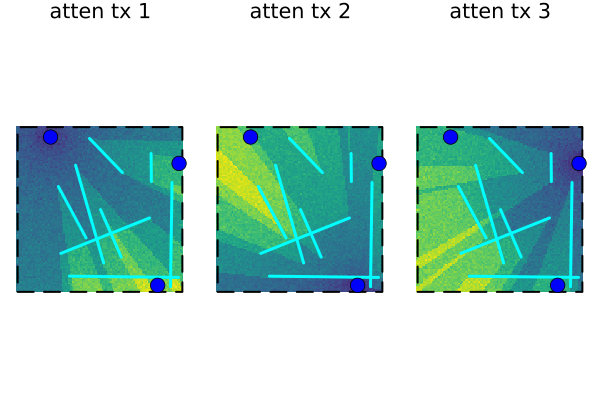

In [13]:
heatmap_plots = [
    plot_discrete_heatmap(room, mw_hmap[:, :, i]; title = @sprintf("atten tx %d", i))
    for i ∈ 1:length(room.transmitters)
]

plot(heatmap_plots..., layout=(1, 3))

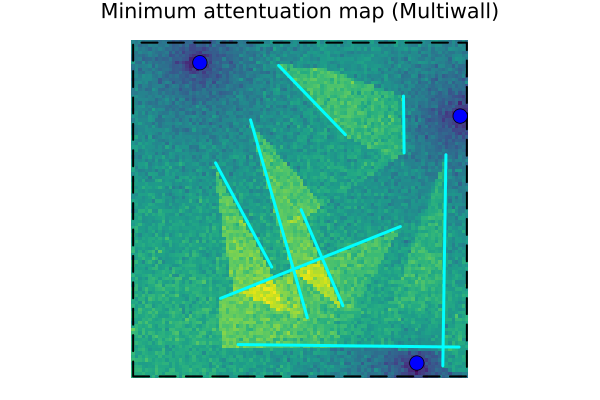

In [14]:
plot_discrete_heatmap(room, minimum(mw_hmap, dims=3)[:, :, 1]; title="Minimum attentuation map (Multiwall)")

### Generation

In [15]:
dim = 128f0
num_walls=10
num_tx=3

trainset = [
    generate_random_room(; dim=dim, num_walls=num_walls, num_tx=num_tx) for _ ∈ 1:9000
]
valset = [
    generate_random_room(; dim=dim, num_walls=num_walls, num_tx=num_tx) for _ ∈ 1:500
]
testset = [
    generate_random_room(; dim=dim, num_walls=num_walls, num_tx=num_tx) for _ ∈ 1:500
];

Random rooms in the training set

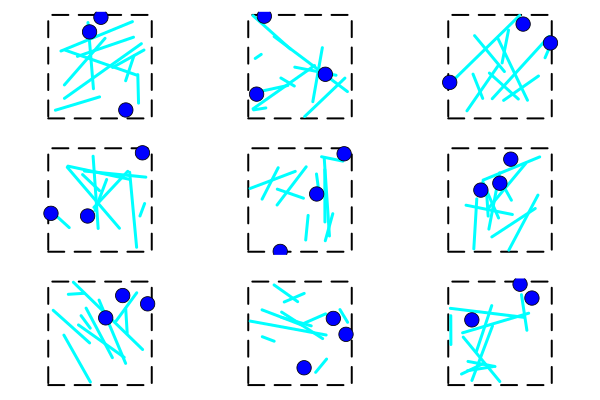

In [16]:
rs = plotroom.(trainset[1:9])

plot(rs..., layout=(3, 3))

Save these to some file so we don't have to lose the generated dataset

In [17]:
using Serialization: serialize, deserialize

In [18]:
serialize("dataset/trainset.dat", trainset)
serialize("dataset/valset.dat", valset)
serialize("dataset/testset.dat", testset)

But we want easier access for training so we convert this into the raster maps and the ground truth.

In [19]:
using Base.Threads: @threads # For faster processing
using ProgressMeter

In [20]:
σ = 3.0f0

function rasterized_set(set; W = 128, H = 128)
    N = length(set)
    # (128, 128, 2 channels, dataset size)
    features = Array{Float32}(undef, W, H, 2, N)
    ground_truth = Array{Float32}(undef, W, H, 3, N)

    p = Progress(N; dt=1.0, desc="Generating Dataset...")

    @threads for i ∈ 1:N
        room = set[i]
        features[:, :, :, i] .= rasterize(room)
        hm = multiwall_heatmap(room; σ=3.0f0)
        ground_truth[:, :, :, i] .= hm
        next!(p)
    end
    features, ground_truth
end

rasterized_set (generic function with 1 method)

In [21]:
X_train, y_train = rasterized_set(trainset; W=128, H=128)
size(X_train), size(y_train)

Generating Dataset... 100%|██████████████████████████████| Time: 0:03:13


((128, 128, 2, 9000), (128, 128, 3, 9000))

In [22]:
X_val, y_val = rasterized_set(valset)
size(X_val), size(y_val)

Generating Dataset... 100%|██████████████████████████████| Time: 0:00:10


((128, 128, 2, 500), (128, 128, 3, 500))

In [23]:
X_test, y_test = rasterized_set(testset)
size(X_test), size(y_test)

Generating Dataset... 100%|██████████████████████████████| Time: 0:00:10


((128, 128, 2, 500), (128, 128, 3, 500))

Serialize all these preprocessed dataset.

In [24]:
serialize("dataset/X_train.dat", X_train)
serialize("dataset/y_train.dat", y_train)

serialize("dataset/X_val.dat", X_val)
serialize("dataset/y_val.dat", y_val)

serialize("dataset/X_test.dat", X_test)
serialize("dataset/y_test.dat", y_test)

98304000

In [25]:
run(`ls -lh dataset`)

total 3.1G
-rw-r--r-- 1 s207399 Domain Users 103K Jan 15 01:47 testset.dat
-rw-r--r-- 1 s207399 Domain Users 1.9M Jan 15 01:47 trainset.dat
-rw-r--r-- 1 s207399 Domain Users 103K Jan 15 01:47 valset.dat
-rw-r--r-- 1 s207399 Domain Users  63M Jan 15 01:51 X_test.dat
-rw-r--r-- 1 s207399 Domain Users 1.1G Jan 15 01:51 X_train.dat
-rw-r--r-- 1 s207399 Domain Users  63M Jan 15 01:51 X_val.dat
-rw-r--r-- 1 s207399 Domain Users  94M Jan 15 01:51 y_test.dat
-rw-r--r-- 1 s207399 Domain Users 1.7G Jan 15 01:51 y_train.dat
-rw-r--r-- 1 s207399 Domain Users  94M Jan 15 01:51 y_val.dat


Process(`ls -lh dataset`, ProcessExited(0))